In [1]:
import scipy.stats as sstats
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import pingouin as pg
from tqdm import tqdm

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror, fix_xlabels
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import cell_tracking as ct
import er_plot_functions as erp
from helpers import flatten, get_eventrate
from stats_utils import resample, get_bootstrap_prob, get_bootstrap_prob_paired
from subjects import save_df, load_df
from behavior import get_thigmotaxis

plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')

### Definitions and helper code

In [4]:
fratio_all = erp.get_all_freezing(err.learners, day_des=[-2, -1, 4, 1,2, 7], arenas=["Open", "Shock"])
fratio_df = erp.fratio_to_df(fratio_all, err.learners, days=[-2, -1, 4, 1,2, 7], 
                             arenas=["Neutral", "Shock"])
fratio_df.head(5)

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181126_1_openfield: nbadpts = 18 max_in_a_row = 3
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4


,Mouse,Arena,Day,Frz. Ratio
0,Marble07,Neutral,-2,0.088444
1,Marble12,Neutral,-2,0.046543
2,Marble24,Neutral,-2,0.050728
3,Marble27,Neutral,-2,0.036380
4,Marble07,Neutral,-1,0.152135


In [2]:
def calc_DI(df_day, neutral_name: str in ["Open", "Neutral"] = "Neutral"):
    frz_neutral = df_day[df_day["Arena"] == neutral_name]["Frz. Ratio"].values[0]
    frz_shock = df_day[df_day["Arena"] == "Shock"]["Frz. Ratio"].values[0]
    DI = (frz_neutral - frz_shock) / (frz_neutral + frz_shock)
    
    return DI

In [3]:
def get_group(row):
    if row.Mouse in err.learners:
        return "Learners"
    elif row.Mouse in err.nonlearners:
        return "Non-Learners"
    elif row.Mouse in err.ani_mice_good:
        return "ANI"
# get_group(DI_df.iloc[0,:])

In [48]:
pfos = pf.load_pf("Marble06", "Shock", 1)
pfoo = pf.load_pf("Marble06", "Open", 1)

In [50]:
event_rate_s, even_prob_s = get_eventrate(pfos.PSAbool_align, pfos.sr_image)
event_rate_o, even_prob_o = get_eventrate(pfoo.PSAbool_align, pfoo.sr_image)

In [55]:
event_rate_comb = np.concatenate((event_rate_s, event_rate_o))
event_rate_comb.shape

(755,)

In [64]:
arena_names = ["Shock"]*len(event_rate_s)
arena_names.extend(["Neutral"]*len(event_rate_o))
len(arena_names)

755

In [70]:
def create_full_neural_metric_df(fratio_df, metric: str, neutral_name: str in ["Open", "Neutral", "Combined"] = "Neutral", 
                                 alpha_pf: float = 0.05):
    """Takes freeze ratio dataframe and converts it to a DataFrame with DI values + MI and event rates
    for all neurons for each mouse in each arena.
    alpha_pf: all cells with p < alpha_pf are considered place fields"""

    assert metric in ["DI Neural", "Coactive", "MI All (Neutral)", "MI All (Shock)", "MI PF (Neutral)", 
                      "MI PF (Shock)", "Event Rate (Neutral)", "Event Rate (Shock)", "Event Rate (Combined)"]

    # Add in Discrimination Index
    # try:
    DI_df = fratio_df.groupby(["Mouse", "Day"], observed=False).apply(calc_DI, include_groups=False).reset_index()
    # DI_df = fratio_df.groupby(["Mouse", "Day"], observed=False).apply(calc_DI).reset_index()
    DI_df = DI_df.rename(columns={0: "DI"})

    # Loop through and get event rate and mutual information
    df_list = []
    for idr, row in DI_df.iterrows():
        
        if not np.isnan(row.DI):
            # Get spatial information and event rate in shock arena
            if "Shock" in metric:
                pfos = pf.load_pf(row["Mouse"], 'Shock', row["Day"])
                if "MI" in metric:
                    mi_shock, _, _, _, _ = pf.spatinfo(pfos.tmap_us, pfos.runoccmap, pfos.PSAbool_align)
                    if "All" in metric:
                        metric_val = mi_shock
                    elif "PF" in metric:
                        metric_val = np.array(mi_shock)[np.array(pfos.pval) < alpha_pf]
                elif ("Event Rate" in metric):
                    event_rate_s, even_prob_s = get_eventrate(pfos.PSAbool_align, pfos.sr_image)
                    metric_val = event_rate_s 
            elif "Neutral" in metric:
                pfoo = pf.load_pf(row["Mouse"], 'Open', row["Day"])
                if "MI" in metric:
                    mi_open, _, _, _, _ = pf.spatinfo(pfoo.tmap_us, pfoo.runoccmap, pfoo.PSAbool_align)
                    if "All" in metric:
                        metric_val = mi_open
                    elif "PF" in metric:
                        mi_pf_open = np.array(mi_open)[np.array(pfoo.pval) < alpha_pf]
                        metric_val = mi_pf_open
                elif ("Event Rate" in metric):
                    event_rate_o, even_prob_o = get_eventrate(pfoo.PSAbool_align, pfoo.sr_image)
                    metric_val = event_rate_o
            elif "Combined" in metric:
                if "Event Rate" in metric:
                    pfos = pf.load_pf(row["Mouse"], 'Shock', row["Day"])
                    pfoo = pf.load_pf(row["Mouse"], 'Open', row["Day"])
                    event_rate_s, even_prob_s = get_eventrate(pfos.PSAbool_align, pfos.sr_image)
                    event_rate_o, even_prob_o = get_eventrate(pfoo.PSAbool_align, pfoo.sr_image)
                    metric_val = np.concatenate((event_rate_s, event_rate_o))

                    arena_names = ["Shock"]*len(event_rate_s)
                    arena_names.extend(["Neutral"]*len(event_rate_o))
                
            elif "DI Neural" in metric:
                di_neural = discr.get_DI_scores(row["Mouse"], 'Open', row["Day"], 'Shock', row["Day"])
                metric_val = di_neural
            elif "Coactive" in metric:
                overlap_bool = pfs.get_overlap_bool(row["Mouse"], 'Open', row["Day"], 'Shock', row["Day"])
                metric_val = overlap_bool.all(axis=1)  # 1 = coactive, 0 = silent (active day 1 only) or new (active day 2 only)
        if "Combined" not in metric:
            df_list.append(pd.DataFrame({"Mouse": row["Mouse"], "Day": row["Day"], metric: metric_val}))
        else:
            df_list.append(pd.DataFrame({"Mouse": row["Mouse"], "Day": row["Day"], metric: metric_val, "Arena": arena_names}))

    return pd.concat(df_list, axis=0)
df_full = create_full_neural_metric_df(fratio_df, "Event Rate (Combined)")
df_full

,Mouse,Day,Event Rate (Combined),Arena
0,Marble17,-2,3.702777,Shock
1,Marble17,-2,6.504879,Shock
2,Marble17,-2,3.802852,Shock
3,Marble17,-2,2.902177,Shock
4,Marble17,-2,2.201651,Shock
...,...,...,...,...
1413,Marble25,7,0.197012,Neutral
1414,Marble25,7,0.492530,Neutral
1415,Marble25,7,3.546216,Neutral
1416,Marble25,7,0.197012,Neutral


### Construct dataframes for use in bootstrapping

In [32]:
days = [-2, -1, 4, 1, 2, 7]
fratio_df_all = []
for mice in (err.learners, err.nonlearners, err.ani_mice_good):
    fratio_all = erp.get_all_freezing(mice, day_des=days, arenas=["Open", "Shock"])
    fratio_df = erp.fratio_to_df(fratio_all, mice, days=days, arenas=["Neutral", "Shock"])
    fratio_df_all.append(fratio_df)
fratio_df_all = pd.concat(fratio_df_all, axis=0)
fratio_df_all["Group"] = fratio_df_all.apply(get_group, axis=1)

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181126_1_openfield: nbadpts = 18 max_in_a_row = 3
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
['Unknown file missing and/or IndexError for Marble06 Open 7']
Freezing left as NaN for this session
['Unknown file missing and/or IndexError for Marble06 Shock 7']
Freezing left as NaN for this session
/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble25/20181203_1_openfield: nbadpts = 9 max_in_a_row = 6


In [33]:
metric = "DI Neural"
df_metric = create_full_neural_metric_df(fratio_df_all, metric)
df_metric["Group"] = df_metric.apply(get_group, axis=1)
df_metric.head(5)

,Mouse,Day,DI Neural,Group
0,Marble06,-2,0.062061,Non-Learners
1,Marble06,-2,0.325274,Non-Learners
2,Marble06,-2,0.229846,Non-Learners
3,Marble06,-2,0.410955,Non-Learners
4,Marble06,-2,0.501404,Non-Learners


In [34]:
df_mean = df_metric.drop(columns="Group").groupby(["Mouse", "Day"]).apply(lambda x: np.mean(np.abs(x))).reset_index()
df_mean = df_mean.rename(columns={0: metric})
df_mean["Group"] = df_mean.apply(get_group, axis=1)
df_mean.sample(5)

,Mouse,Day,DI Neural,Group
12,Marble11,-2,0.270837,Non-Learners
43,Marble20,-1,0.370188,ANI
42,Marble20,-2,0.393848,ANI
66,Marble29,-2,0.321017,Non-Learners
55,Marble25,-1,0.328164,ANI


<Axes: xlabel='Group', ylabel='DI Neural'>

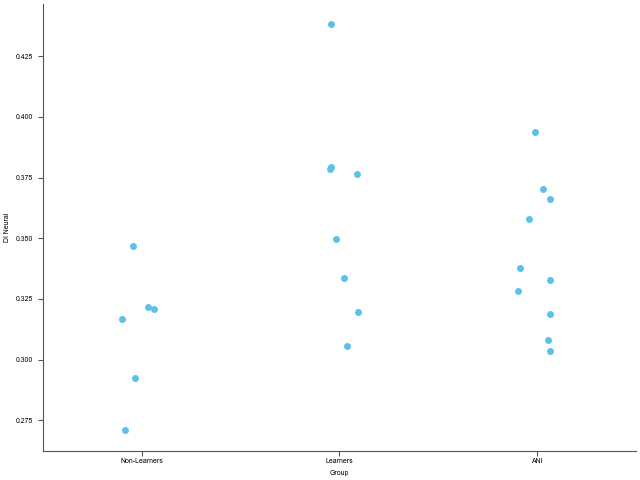

In [35]:
# Sanity check plot - should match Fig1 plots!
_, ax = plt.subplots()
sns.stripplot(data=df_mean[(df_mean.Day == -1) | (df_mean.Day == -2)], x="Group", y=metric, ax=ax)

In [36]:
pg.pairwise_tests(data=df_mean[(df_mean.Day == -1) | (df_mean.Day == -2)], dv=metric, between="Group", within="Day", subject="Mouse",
                 within_first=False)

/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:7702: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:7694: RuntimeWarning: divide by zero encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/pingouin/pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace 

,Contrast,Group,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,Group,-,ANI,Learners,False,True,-0.735475,5.353998,two-sided,0.492992,0.598,-0.456185
1,Group,-,ANI,Non-Learners,False,True,1.457173,4.814263,two-sided,0.207035,0.922,0.893821
2,Group,-,Learners,Non-Learners,False,True,1.858819,4.960855,two-sided,0.122615,1.198,1.114617
3,Day,-,-2,-1,True,True,0.310017,11.000000,two-sided,0.762342,0.3,0.052492
4,Group * Day,ANI,-2,-1,True,True,0.217481,4.000000,two-sided,0.838477,0.405,0.038673
5,Group * Day,Learners,-2,-1,True,True,0.940932,3.000000,two-sided,0.416155,0.591,0.293009
6,Group * Day,Non-Learners,-2,-1,True,True,-1.449658,2.000000,two-sided,0.284197,0.848,-0.398849


## Bootstrap Neural DI, Mutual Information, (and Cell Overlap)?

[8.5   4.875]
[8.5   4.875]


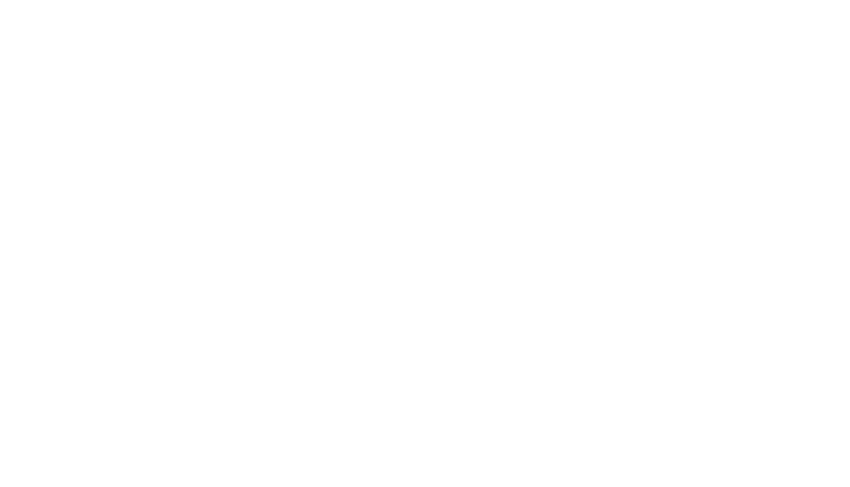

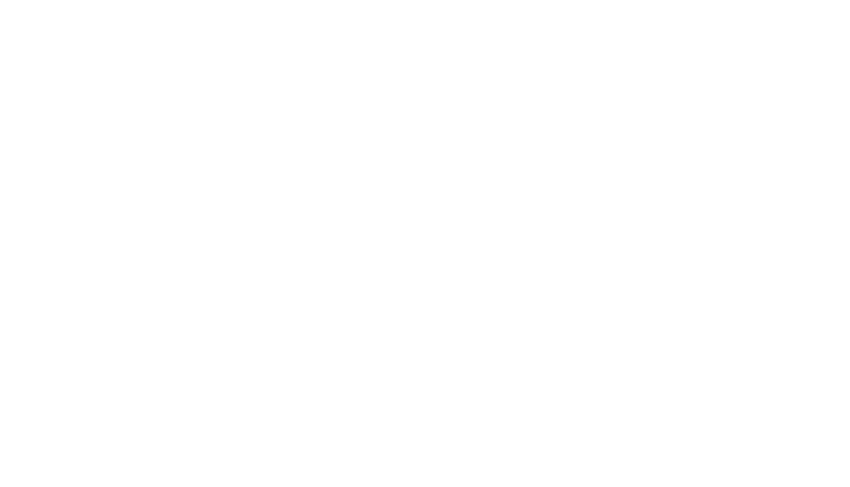

In [16]:
# Set up main figure plotting
%matplotlib ipympl
FigDI2 = Fig(num="FigDI2", grid=(4, 5), size=(8.5, 4.875), fontsize=5)
print(FigDI2.fig.get_size_inches())

# Set up main figure stats companion plot and mirror it into FigMirror class
FigDI2stats = Fig(num='FigDI2 stats', grid=(4, 5), size=(8.5, 4.875), fontsize=5)
print(FigDI2stats.fig.get_size_inches())
FigDI2comb = FigMirror(FigDI2, FigDI2stats)

### Day -1 and -2 combined, sampling two days in same bootstrap
Not used.

In [ ]:
metrics = ["DI Neural", "MI All (Neutral)", "MI PF (Neutral)", "Event Rate (Neutral)", "IQR (Neutral)",
           "Coactive", "MI All (Shock)",  "MI PF (Shock)", "Event Rate (Shock)", "IQR (Shock)"]
comps = [["Learners", "Non-Learners"], ["Learners", "ANI"], ["Non-Learners", "ANI"]]
n_iter = 10000
palette = sns.color_palette(palette='Set2', as_cmap=False)[0:3]

for idm, metric in enumerate(metrics):

    # Skip boostrapping for IQR if already calculated during event rate bootstrappin:
    if ((metric == "IQR (Neutral)") & ("Event Rate (Neutral)" in df_metric.keys())) | ((metric == "IQR (Shock)") & ("Event Rate (Shock)" in df_metric.keys())):
        print("Skipping bootstrapping for IQR because already done")
    else:    
        df_bs = []
        
        df_metric = create_full_neural_metric_df(fratio_df_all, metric)
        df_metric["Group"] = df_metric.apply(get_group, axis=1)
        df_metric = df_metric[(df_metric.Day == -2) | (df_metric.Day == -1)]  # Grab only values for BEFORE days
        print(f"Metric #{idm} ({metric}) bootstrapping")
        for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                    [err.learners, err.nonlearners, err.ani_mice_good]):
            df_list = []
            df_use = df_metric[df_metric.Group == group_name].drop(columns="Group")
            means, iqr = [], []
            print(f"Bootstrapping for {group_name} group")
            for ii in tqdm(range(n_iter)):
                t = resample(df_use, level=["Mouse", "Day", metric])
                if metric in "DI Neural":
                    means.append(np.mean(np.abs(t[metric].values)))
                else:
                    means.append(np.mean(t[metric].values))
                    if "Event Rate" in metric:
                        iqr.append(sstats.iqr(t[metric].values))
            
            if "Event Rate" in metric:
                df_bs.append(pd.DataFrame({"Group": group_name, metric: means, f"IQR {metric.split(' ')[-1]}": iqr}))
            else:
                df_bs.append(pd.DataFrame({"Group": group_name, metric: means}))
                
        df_bs = pd.concat(df_bs, axis=0)
    
    ax = FigDI2comb.subplot((FigDI2.gs.nrows, FigDI2.gs.ncols, 1 + idm))

    if metric == "DI Neural":
        df_metric[metric] = np.abs(df_metric[metric])
    if "IQR" in metric:
        df_mean = df_metric.drop(columns=["Group", "Day"]).groupby(["Mouse"]).apply(sstats.iqr).reset_index()
        df_mean = df_mean.rename(columns={0: f"IQR {metric.split(' ')[-1]}"})
    else:
        df_mean = df_metric.groupby(["Mouse"]).mean(numeric_only=True).reset_index()
    df_mean["Group"] = pd.Categorical(df_mean.apply(get_group, axis=1), ["Learners", "Non-Learners", "ANI"])
    
    sns.boxplot(data=df_bs, x="Group", y=metric, palette=palette, showfliers=False, hue="Group", 
                linewidth=0.5, fill=False, legend=False, ax=ax[0])
    sns.stripplot(data=df_mean, x="Group", y=metric, palette=palette, size=3, linewidth=0.3, edgecolor="w", hue="Group", 
                  legend=False, ax=ax[0])
    ax[0].set_xlabel("")
    if metric == "Coactive":
        ax[0].set_ylabel("Overlap Ratio")
    
    ax[1].text(0.1, 0.9, f"bootstrap test stats for {metric}")
    for idg, (grp1, grp2) in enumerate(comps):
        stat, pval = get_bootstrap_prob(df_bs[df_bs.Group == grp1][metric], df_bs[df_bs.Group == grp2][metric])
        ax[1].text(0.1, 0.7 - idg * 0.2, f"{grp1} v {grp2}: pval = {pval:.3g}, test_stat = {stat:0.3f}")
        ax[1].text(0.1, 0.6 - idg * 0.2, f"pval = {np.min((pval*len(comps), 1)):.3g} after Bonf. corr.")

FigDI2comb.savefig(plot_path=plot_path, file_prefix="Pre_Neural_Metrics_Dayn1_n2_comb_bs", suffix=["", "_stats"], 
                   scriptname="behavioral_and_neural_discrimnination_bootstrap.ipynb")
FigDI2.fig

Metric #0 (DI Neural) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:31<00:00, 315.18it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:27<00:00, 366.30it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:42<00:00, 233.47it/s]
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: divide by zero encountered in log
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: invalid value encountered in multiply
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:618: RuntimeWarning: divide by zero encountered in log2
  isec.append(np.nansum(p1xtemp * p_x * np.log2(p1xtemp / p_k1[neuron])))
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:618: RuntimeWarning: invalid value encountered in multiply
  isec.append(np.nansum(p1xtemp * p_x * np.log2(p1xtemp / p_k1[neuron])))
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:608: RuntimeWarning: divide by zero encountered in log
  i_k0 = p0xtemp * np.log(p0xtemp / p_k0[neuron])  # All

Metric #1 (MI All (Neutral)) bootstrapping
Bootstrapping for Learners group


 26%|█████████▌                           | 2575/10000 [00:09<00:27, 274.43it/s]

In [ ]:
FigDI2stats.fig

### Look at only Day -1
consistent with other plots to not count data from two sessions from the same mouse. Not used.


In [130]:
# Set up main figure plotting
%matplotlib ipympl
FigDI2 = Fig(num="FigDI2", grid=(4, 5), size=(8.5, 4.875), fontsize=5)
print(FigDI2.fig.get_size_inches())

# Set up main figure stats companion plot and mirror it into FigMirror class
FigDI2stats = Fig(num='FigDI2 stats', grid=(4, 5), size=(8.5, 4.875), fontsize=5)
print(FigDI2stats.fig.get_size_inches())
FigDI2comb = FigMirror(FigDI2, FigDI2stats)

[8.5   4.875]
[8.5   4.875]


Metric #0 (DI Neural) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 464.26it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 573.07it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.63it/s]
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: divide by zero encountered in log
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: invalid value encountered in multiply
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:618: RuntimeWarning: divide by zero encountered in log2
  isec.append(np.nansum(p1xtemp * p_x * np.log2(p1xtemp / p_k1[neuron])))
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:618: RuntimeWarning: invalid value encountered in multiply
  isec.append(np.nansum(p1xtemp * p_x * np.log2(p1xtemp / p_k1[neuron])))
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:608: RuntimeWarning: divide by zero encountered in log
  i_k0 = p0xtemp * np.log(p0xtem

Metric #1 (MI All (Neutral)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.14it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 524.97it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.38it/s]
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: divide by zero encountered in log
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: invalid value encountered in multiply
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:618: RuntimeWarning: divide by zero encountered in log2
  isec.append(np.nansum(p1xtemp * p_x * np.log2(p1xtemp / p_k1[neuron])))
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:618: RuntimeWarning: invalid value encountered in multiply
  isec.append(np.nansum(p1xtemp * p_x * np.log2(p1xtemp / p_k1[neuron])))
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:608: RuntimeWarning: divide by zero encountered in log
  i_k0 = p0xtemp * np.log(p0xtem

Metric #2 (MI PF (Neutral)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 492.26it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 644.22it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.29it/s]


Metric #3 (Event Rate (Neutral)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.73it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 454.43it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 291.84it/s]


Skipping bootstrapping for IQR because already done
Metric #5 (Coactive) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.80it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 476.68it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 285.48it/s]
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: divide by zero encountered in log
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: invalid value encountered in multiply
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:608: RuntimeWarning: divide by zero encountered in log
  i_k0 = p0xtemp * np.log(p0xtemp / p_k0[neuron])  # All good values
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:608: RuntimeWarning: invalid value encountered in multiply
  i_k0 = p0xtemp * np.log(p0xtemp / p_k0[neuron])  # All good values
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:618: RuntimeWarning: divide by zero encountered in log2
  isec.append(np.nansum(p1xtemp * p_x * np

Metric #6 (MI All (Shock)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.99it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 521.83it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.43it/s]
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: divide by zero encountered in log
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: invalid value encountered in multiply
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:608: RuntimeWarning: divide by zero encountered in log
  i_k0 = p0xtemp * np.log(p0xtemp / p_k0[neuron])  # All good values
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:608: RuntimeWarning: invalid value encountered in multiply
  i_k0 = p0xtemp * np.log(p0xtemp / p_k0[neuron])  # All good values
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:618: RuntimeWarning: divide by zero encountered in log2
  isec.append(np.nansum(p1xtemp * p_x * np

Metric #7 (MI PF (Shock)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 507.51it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 656.21it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.49it/s]


Metric #8 (Event Rate (Shock)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.61it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 460.01it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 308.72it/s]


Skipping bootstrapping for IQR because already done


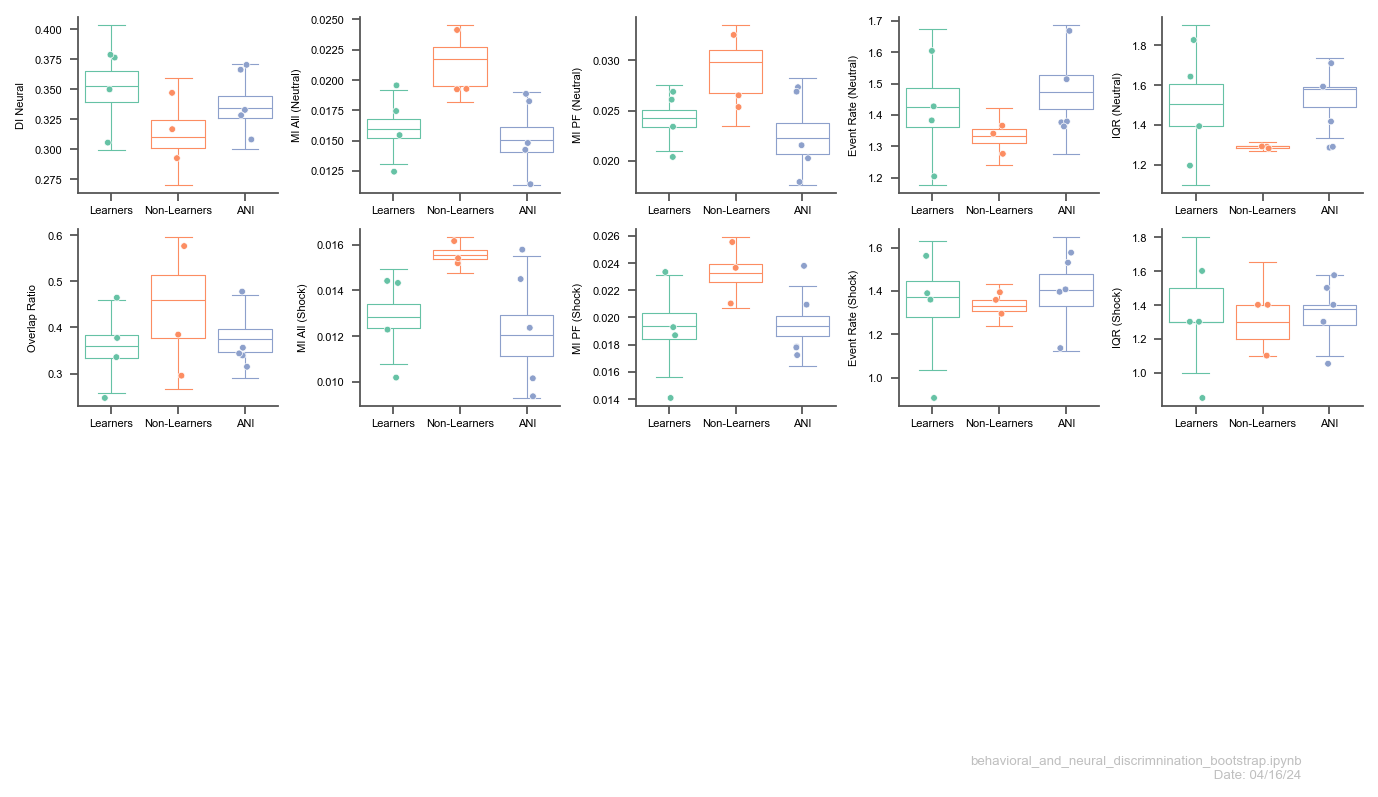

In [131]:
metrics = ["DI Neural", "MI All (Neutral)", "MI PF (Neutral)", "Event Rate (Neutral)", "IQR (Neutral)",
           "Coactive", "MI All (Shock)",  "MI PF (Shock)", "Event Rate (Shock)", "IQR (Shock)"]
comps = [["Learners", "Non-Learners"], ["Learners", "ANI"], ["Non-Learners", "ANI"]]
n_iter = 10000
palette = sns.color_palette(palette='Set2', as_cmap=False)[0:3]

for idm, metric in enumerate(metrics):

    # Skip boostrapping for IQR if already calculated during event rate bootstrapping:
    if ((metric == "IQR (Neutral)") & ("Event Rate (Neutral)" in df_metric.keys())) | ((metric == "IQR (Shock)") & ("Event Rate (Shock)" in df_metric.keys())):
        print("Skipping bootstrapping for IQR because already done")
    else:    
        df_bs = []
        
        df_metric = create_full_neural_metric_df(fratio_df_all, metric)
        df_metric["Group"] = df_metric.apply(get_group, axis=1)
        df_metric = df_metric[(df_metric.Day == -1)]  # Grab only values for BEFORE days
        print(f"Metric #{idm} ({metric}) bootstrapping")
        for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                    [err.learners, err.nonlearners, err.ani_mice_good]):
            df_list = []
            df_use = df_metric[df_metric.Group == group_name].drop(columns="Group")
            means, iqr = [], []
            print(f"Bootstrapping for {group_name} group")
            for ii in tqdm(range(n_iter)):
                t = resample(df_use, level=["Mouse", "Day", metric])
                if metric in "DI Neural":
                    means.append(np.mean(np.abs(t[metric].values)))
                else:
                    means.append(np.mean(t[metric].values))
                    if "Event Rate" in metric:
                        iqr.append(sstats.iqr(t[metric].values))
            
            if "Event Rate" in metric:
                df_bs.append(pd.DataFrame({"Group": group_name, metric: means, f"IQR {metric.split(' ')[-1]}": iqr}))
            else:
                df_bs.append(pd.DataFrame({"Group": group_name, metric: means}))
                
        df_bs = pd.concat(df_bs, axis=0)
    
    ax = FigDI2comb.subplot((FigDI2.gs.nrows, FigDI2.gs.ncols, 1 + idm))

    if metric == "DI Neural":
        df_metric[metric] = np.abs(df_metric[metric])
    if "IQR" in metric:
        df_mean = df_metric.drop(columns=["Group", "Day"]).groupby(["Mouse"]).apply(sstats.iqr).reset_index()
        df_mean = df_mean.rename(columns={0: f"IQR {metric.split(' ')[-1]}"})
    else:
        df_mean = df_metric.groupby(["Mouse"]).mean(numeric_only=True).reset_index()
    df_mean["Group"] = pd.Categorical(df_mean.apply(get_group, axis=1), ["Learners", "Non-Learners", "ANI"])
    
    sns.boxplot(data=df_bs, x="Group", y=metric, palette=palette, showfliers=False, hue="Group", 
                linewidth=0.5, fill=False, legend=False, ax=ax[0])
    sns.stripplot(data=df_mean, x="Group", y=metric, palette=palette, size=3, linewidth=0.3, edgecolor="w", hue="Group", 
                  legend=False, ax=ax[0])
    ax[0].set_xlabel("")
    if metric == "Coactive":
        ax[0].set_ylabel("Overlap Ratio")
    
    ax[1].text(0.1, 0.9, f"bootstrap test stats for {metric}")
    for idg, (grp1, grp2) in enumerate(comps):
        stat, pval = get_bootstrap_prob(df_bs[df_bs.Group == grp1][metric], df_bs[df_bs.Group == grp2][metric])
        ax[1].text(0.1, 0.7 - idg * 0.2, f"{grp1} v {grp2}: pval = {pval:.3g}, test_stat = {stat:0.3f}")
        ax[1].text(0.1, 0.6 - idg * 0.2, f"pval = {np.min((pval*len(comps), 1)):.3g} after Bonf. corr.")
FigDI2comb.savefig(plot_path=plot_path, file_prefix="Pre_Neural_Metrics_Dayn1_only_bs", suffix=["", "_stats"], 
                   scriptname="behavioral_and_neural_discrimnination_bootstrap.ipynb")
FigDI2.fig

/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


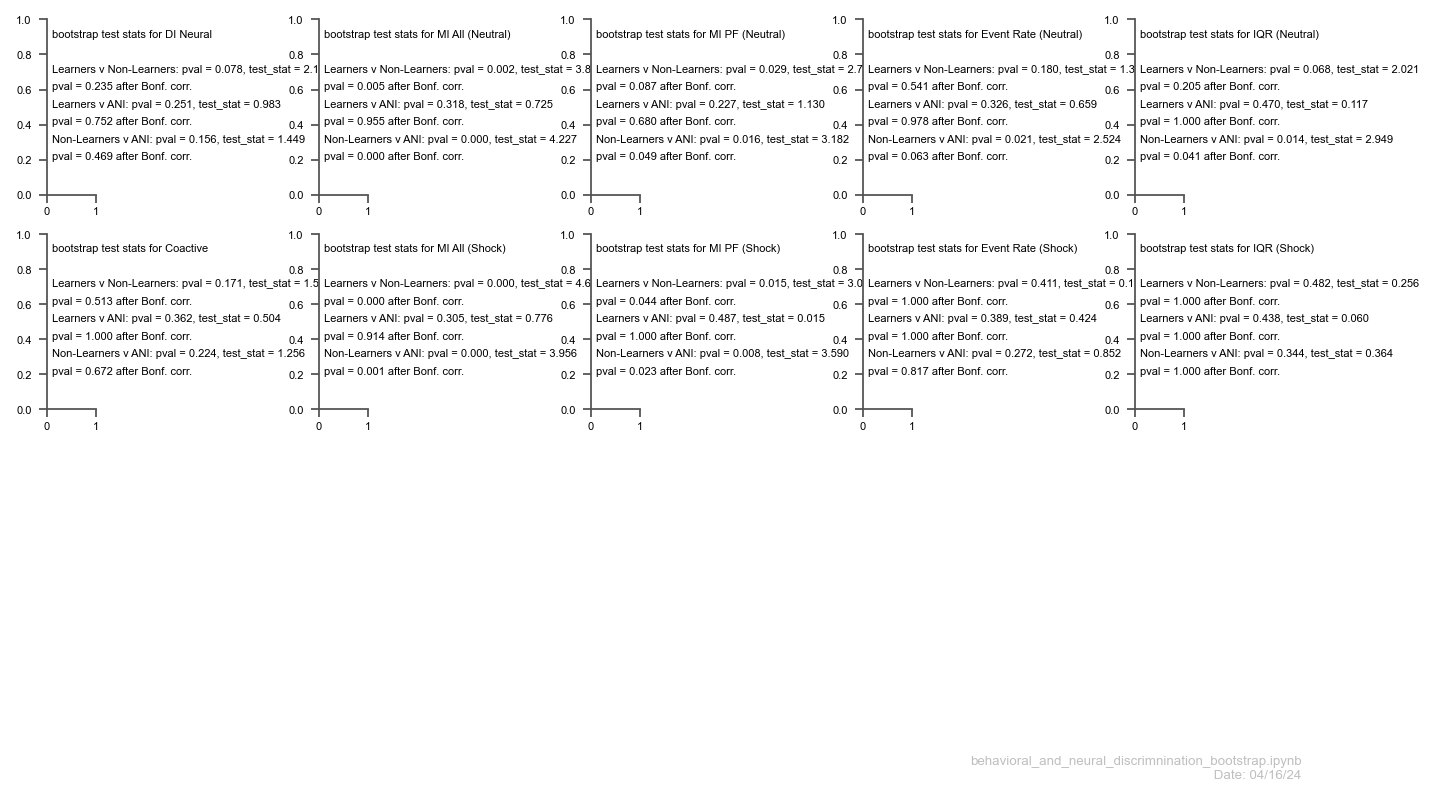

In [132]:
FigDI2stats.fig

### Figure 1H and SBehavioralA-C: Look at both day -2 and day -1 but make sure to select only ONE session from each mouse during bootstrapping.
Most faithful to ethos of HB - bootstrap in a way that mimics how you would do the experiment if you had infinite mice/sessions.

In [120]:
# Set up main figure plotting
%matplotlib ipympl
FigDI2 = Fig(num="FigDI2", grid=(4, 5), size=(8.5, 4.875), fontsize=6)
print(FigDI2.fig.get_size_inches())

# Set up main figure stats companion plot and mirror it into FigMirror class
FigDI2stats = Fig(num='FigDI2 stats', grid=(4, 5), size=(8.5, 4.875), fontsize=5)
print(FigDI2stats.fig.get_size_inches())
FigDI2comb = FigMirror(FigDI2, FigDI2stats)

[8.5   4.875]
[8.5   4.875]


Metric #0 (DI Neural) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:22<00:00, 449.63it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:19<00:00, 511.78it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:30<00:00, 327.63it/s]
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:60: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=df_bs_plot, x="Group", y=metric, palette=palette, showfliers=False, hue="Group",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:63: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(data=df_mean_plot, x="Group", y=metric, palette=palette, size=3, linewidth=0.3, edgecolor="w", hue="Group",
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: divide by zero encountered in log
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: invalid value encountered in multiply
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[n

Metric #1 (MI All (Neutral)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:26<00:00, 380.09it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:23<00:00, 429.04it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:37<00:00, 263.50it/s]
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:60: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=df_bs_plot, x="Group", y=metric, palette=palette, showfliers=False, hue="Group",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:63: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(data=df_mean_plot, x="Group", y=metric, palette=palette, size=3, linewidth=0.3, edgecolor="w", hue="Group",
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: divide by zero encountered in log
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: invalid value encountered in multiply
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[n

Metric #2 (MI PF (Neutral)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:20<00:00, 481.54it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:15<00:00, 633.80it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:26<00:00, 375.79it/s]
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:60: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=df_bs_plot, x="Group", y=metric, palette=palette, showfliers=False, hue="Group",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:63: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(data=df_mean_plot, x="Group", y=metric, palette=palette, size=3, linewidth=0.3, edgecolor="w", hue="Group",


Metric #3 (Event Rate (Neutral)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:28<00:00, 346.55it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 396.65it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:40<00:00, 248.82it/s]
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:60: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=df_bs_plot, x="Group", y=metric, palette=palette, showfliers=False, hue="Group",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:63: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(data=df_mean_plot, x="Group", y=metric, palette=palette, size=3, linewidth=0.3, edgecolor="w", hue="Group",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:60: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=df_bs_plot, x="Group", y=metric, palette=palette, showfliers=False, hue="Group",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/318

Skipping bootstrapping for IQR because already done
Metric #5 (Coactive) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:29<00:00, 339.22it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:24<00:00, 400.61it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:43<00:00, 230.91it/s]
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:60: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=df_bs_plot, x="Group", y=metric, palette=palette, showfliers=False, hue="Group",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:63: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(data=df_mean_plot, x="Group", y=metric, palette=palette, size=3, linewidth=0.3, edgecolor="w", hue="Group",
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: divide by zero encountered in log
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: invalid value encountered in multiply
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[n

Metric #6 (MI All (Shock)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:24<00:00, 403.87it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:21<00:00, 464.38it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:34<00:00, 289.03it/s]
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:60: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=df_bs_plot, x="Group", y=metric, palette=palette, showfliers=False, hue="Group",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:63: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(data=df_mean_plot, x="Group", y=metric, palette=palette, size=3, linewidth=0.3, edgecolor="w", hue="Group",
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: divide by zero encountered in log
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: invalid value encountered in multiply
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[n

Metric #7 (MI PF (Shock)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:19<00:00, 514.17it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:15<00:00, 657.80it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:24<00:00, 411.34it/s]
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:60: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=df_bs_plot, x="Group", y=metric, palette=palette, showfliers=False, hue="Group",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:63: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(data=df_mean_plot, x="Group", y=metric, palette=palette, size=3, linewidth=0.3, edgecolor="w", hue="Group",


Metric #8 (Event Rate (Shock)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:26<00:00, 381.79it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:23<00:00, 432.30it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:36<00:00, 274.59it/s]
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:60: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=df_bs_plot, x="Group", y=metric, palette=palette, showfliers=False, hue="Group",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:63: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(data=df_mean_plot, x="Group", y=metric, palette=palette, size=3, linewidth=0.3, edgecolor="w", hue="Group",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:60: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=df_bs_plot, x="Group", y=metric, palette=palette, showfliers=False, hue="Group",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/318

Skipping bootstrapping for IQR because already done
Metric #10 (Event Rate (Combined)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:49<00:00, 202.84it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:46<00:00, 214.48it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [01:13<00:00, 136.86it/s]
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:60: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=df_bs_plot, x="Group", y=metric, palette=palette, showfliers=False, hue="Group",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:63: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(data=df_mean_plot, x="Group", y=metric, palette=palette, size=3, linewidth=0.3, edgecolor="w", hue="Group",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/3184651291.py:60: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=df_bs_plot, x="Group", y=metric, palette=palette, showfliers=False, hue="Group",
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_8325/318

Skipping bootstrapping for IQR because already done


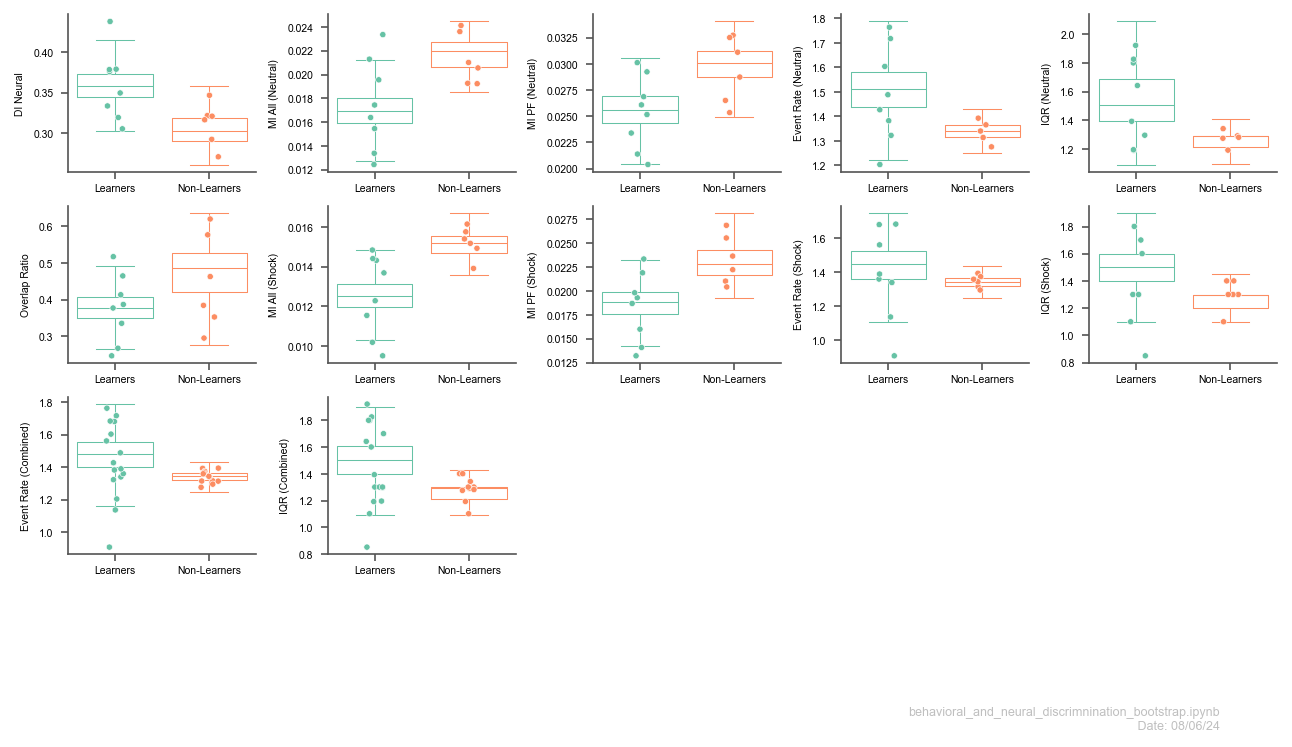

In [121]:
metrics = ["DI Neural", "MI All (Neutral)", "MI PF (Neutral)", "Event Rate (Neutral)", "IQR (Neutral)",
           "Coactive", "MI All (Shock)",  "MI PF (Shock)", "Event Rate (Shock)", "IQR (Shock)",
          "Event Rate (Combined)", "IQR (Combined)"]
comps = [["Learners", "Non-Learners"], ["Learners", "ANI"], ["Non-Learners", "ANI"]]
exclude_ani = True
n_iter = 10000
palette = sns.color_palette(palette='Set2', as_cmap=False)[0:3]

for idm, metric in enumerate(metrics):

    # Skip boostrapping for IQR if already calculated during event rate bootstrapping:
    if ((metric == "IQR (Neutral)") & ("Event Rate (Neutral)" in df_metric.keys())) | ((metric == "IQR (Shock)") & ("Event Rate (Shock)" in df_metric.keys())) | ((metric == "IQR (Combined)") & ("Event Rate (Combined)" in df_metric.keys())):
        print("Skipping bootstrapping for IQR because already done")
    else:    
        df_bs = []
        
        df_metric = create_full_neural_metric_df(fratio_df_all, metric)
        df_metric["Group"] = df_metric.apply(get_group, axis=1)
        df_metric = df_metric[(df_metric.Day == -2) | (df_metric.Day == -1)]  # Grab only values for BEFORE days
        print(f"Metric #{idm} ({metric}) bootstrapping")
        for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                    [err.learners, err.nonlearners, err.ani_mice_good]):
            df_list = []
            df_use = df_metric[df_metric.Group == group_name].drop(columns="Group")
            means, iqr = [], []
            print(f"Bootstrapping for {group_name} group")
            for ii in tqdm(range(n_iter)):
                if "Combined" not in metric:
                    t = resample(df_use, level=["Mouse", "Day", metric], n_level=[None, 1, None])
                else:  # only grab one session per animal from either arena
                    t = resample(df_use, level=["Mouse", "Day", "Arena", metric], n_level=[None, 1, 1, None])
                if metric in "DI Neural":
                    means.append(np.mean(np.abs(t[metric].values)))
                else:
                    means.append(np.mean(t[metric].values))
                    if "Event Rate" in metric:
                        iqr.append(sstats.iqr(t[metric].values))
            
            if "Event Rate" in metric:
                df_bs.append(pd.DataFrame({"Group": group_name, metric: means, f"IQR {metric.split(' ')[-1]}": iqr}))
            else:
                df_bs.append(pd.DataFrame({"Group": group_name, metric: means}))
                
        df_bs = pd.concat(df_bs, axis=0)
    
    ax = FigDI2comb.subplot((FigDI2.gs.nrows, FigDI2.gs.ncols, 1 + idm))

    groupby = ["Mouse", "Day"] if ("Combined" not in metric) else ["Mouse", "Day", "Arena"]
    if metric == "DI Neural":
        df_metric[metric] = np.abs(df_metric[metric])
    if "IQR" in metric:
        df_mean = df_metric.drop(columns=["Group"]).groupby(groupby).apply(sstats.iqr).reset_index()
        df_mean = df_mean.rename(columns={0: f"IQR {metric.split(' ')[-1]}"})
    else:
        df_mean = df_metric.groupby(groupby).mean(numeric_only=True).reset_index()
    cats = ["Learners", "Non-Learners"] if exclude_ani else ["Learners", "Non-Learners", "ANI"]
    df_mean["Group"] = pd.Categorical(df_mean.apply(get_group, axis=1), cats)

    df_bs_plot = df_bs[df_bs.Group != "ANI"] if exclude_ani else df_bs
    sns.boxplot(data=df_bs_plot, x="Group", y=metric, palette=palette, showfliers=False, hue="Group", 
                linewidth=0.5, fill=False, legend=False, ax=ax[0])
    df_mean_plot = df_mean[df_mean.Group != "ANI"] if exclude_ani else df_mean
    sns.stripplot(data=df_mean_plot, x="Group", y=metric, palette=palette, size=3, linewidth=0.3, edgecolor="w", hue="Group", 
                  legend=False, ax=ax[0])
    ax[0].set_xlabel("")
    if metric == "Coactive":
        ax[0].set_ylabel("Overlap Ratio")
    
    ax[1].text(0.1, 0.9, f"bootstrap test stats for {metric}")
    for idg, (grp1, grp2) in enumerate(comps):
        stat, pval = get_bootstrap_prob(df_bs[df_bs.Group == grp1][metric], df_bs[df_bs.Group == grp2][metric])
        ax[1].text(0.1, 0.7 - idg * 0.2, f"{grp1} v {grp2}: pval = {pval:.3g}, test_stat = {stat:0.3g}")
        ax[1].text(0.1, 0.6 - idg * 0.2, f"pval = {np.min((pval*len(comps), 1)):.3g} after Bonf. corr.")

ani_append = "no_ani" if exclude_ani else ""
FigDI2comb.savefig(plot_path=plot_path, file_prefix="Pre_Neural_Metrics_Dayn1_or_n2_bs", suffix=[f"_{ani_append}", f"_{ani_append}_stats"], 
                   scriptname="behavioral_and_neural_discrimnination_bootstrap.ipynb")
FigDI2.fig

/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


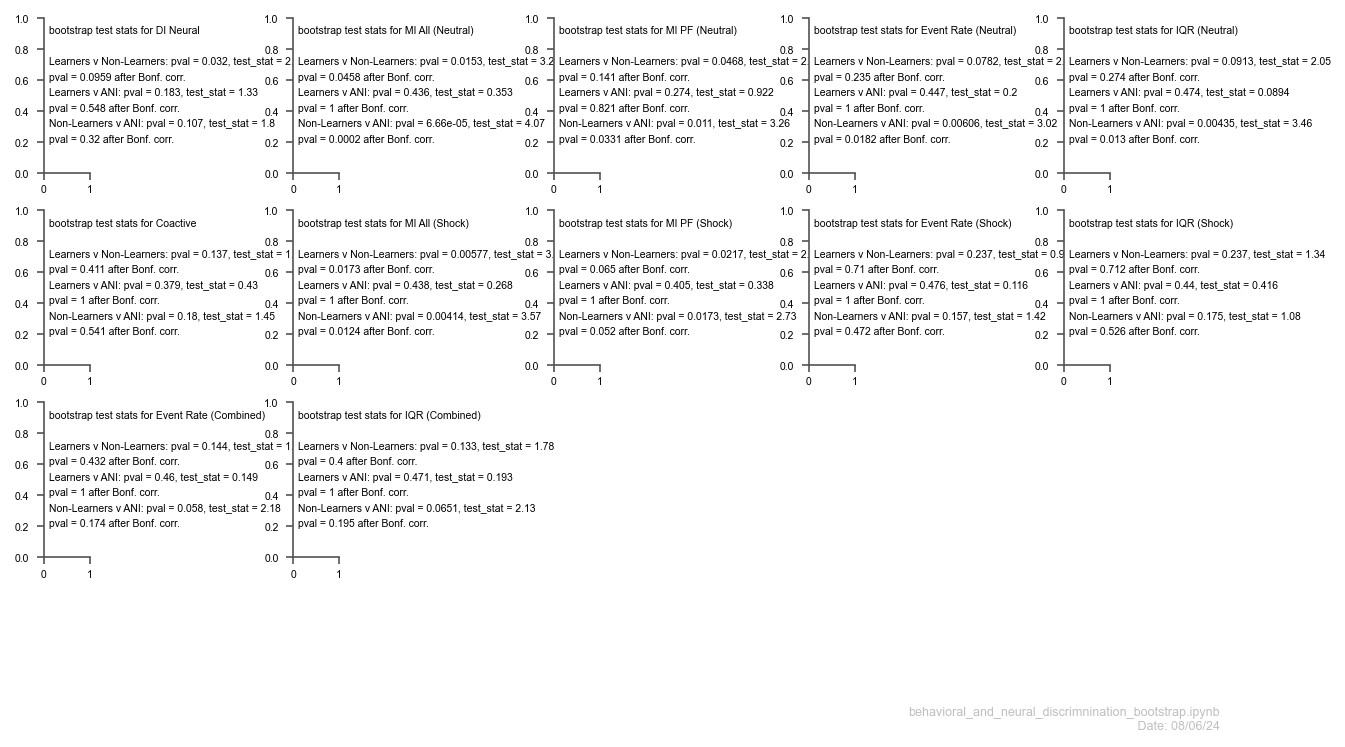

In [122]:
FigDI2stats.fig

### After (Days 1 and 2) plots

In [44]:
# Set up main figure plotting
%matplotlib ipympl
FigDI2a = Fig(num="FigDI2a", grid=(4, 5), size=(8.5, 4.875), fontsize=6)
print(FigDI2a.fig.get_size_inches())

# Set up main figure stats companion plot and mirror it into FigMirror class
FigDI2astats = Fig(num='FigDI2a stats', grid=(4, 5), size=(8.5, 4.875), fontsize=5)
print(FigDI2astats.fig.get_size_inches())
FigDI2acomb = FigMirror(FigDI2a, FigDI2astats)

[8.5   4.875]
[8.5   4.875]


Metric #0 (DI Neural) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:23<00:00, 418.00it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:18<00:00, 537.71it/s]


Bootstrapping for ANI group


100%|█████████████████████████████████████| 10000/10000 [22:01<00:00,  7.57it/s]
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: divide by zero encountered in log
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: invalid value encountered in multiply
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:618: RuntimeWarning: divide by zero encountered in log2
  isec.append(np.nansum(p1xtemp * p_x * np.log2(p1xtemp / p_k1[neuron])))
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:618: RuntimeWarning: invalid value encountered in multiply
  isec.append(np.nansum(p1xtemp * p_x * np.log2(p1xtemp / p_k1[neuron])))
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:608: RuntimeWarning: divide by zero encountered in log
  i_k0 = p0xtemp * np.log(p0xtemp / p_k0[neuron])  # All

Metric #1 (MI All (Neutral)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:24<00:00, 408.91it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:20<00:00, 480.84it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:42<00:00, 237.62it/s]
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: divide by zero encountered in log
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: invalid value encountered in multiply
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:618: RuntimeWarning: divide by zero encountered in log2
  isec.append(np.nansum(p1xtemp * p_x * np.log2(p1xtemp / p_k1[neuron])))
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:618: RuntimeWarning: invalid value encountered in multiply
  isec.append(np.nansum(p1xtemp * p_x * np.log2(p1xtemp / p_k1[neuron])))
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:608: RuntimeWarning: divide by zero encountered in log
  i_k0 = p0xtemp * np.log(p0xtemp / p_k0[neuron])  # All

Metric #2 (MI PF (Neutral)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:21<00:00, 475.32it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:15<00:00, 638.21it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 397.73it/s]


Metric #3 (Event Rate (Neutral)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:27<00:00, 365.26it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:23<00:00, 429.35it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:38<00:00, 260.97it/s]


Skipping bootstrapping for IQR because already done
Metric #5 (Coactive) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:27<00:00, 359.06it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:24<00:00, 411.66it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:40<00:00, 248.97it/s]
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: divide by zero encountered in log
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: invalid value encountered in multiply
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:608: RuntimeWarning: divide by zero encountered in log
  i_k0 = p0xtemp * np.log(p0xtemp / p_k0[neuron])  # All good values
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:608: RuntimeWarning: invalid value encountered in multiply
  i_k0 = p0xtemp * np.log(p0xtemp / p_k0[neuron])  # All good values
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:618: RuntimeWarning: divide by zero encountered in log2
  isec.append(np.nansum(p1xtemp * p_x * np.log2(p1xtemp / p_k1[neu

Metric #6 (MI All (Shock)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 399.52it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:22<00:00, 440.37it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:35<00:00, 285.36it/s]
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: divide by zero encountered in log
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:607: RuntimeWarning: invalid value encountered in multiply
  i_k1 = p1xtemp * np.log(p1xtemp / p_k1[neuron])  # Lots of nans - why?
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:608: RuntimeWarning: divide by zero encountered in log
  i_k0 = p0xtemp * np.log(p0xtemp / p_k0[neuron])  # All good values
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:608: RuntimeWarning: invalid value encountered in multiply
  i_k0 = p0xtemp * np.log(p0xtemp / p_k0[neuron])  # All good values
/Users/nkinsky/Documents/BU/GitHub/Eraser/Placefields.py:618: RuntimeWarning: divide by zero encountered in log2
  isec.append(np.nansum(p1xtemp * p_x * np.log2(p1xtemp / p_k1[neu

Metric #7 (MI PF (Shock)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:20<00:00, 487.56it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:16<00:00, 622.55it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 386.33it/s]


Metric #8 (Event Rate (Shock)) bootstrapping
Bootstrapping for Learners group


100%|████████████████████████████████████| 10000/10000 [00:28<00:00, 354.44it/s]


Bootstrapping for Non-Learners group


100%|████████████████████████████████████| 10000/10000 [00:24<00:00, 409.37it/s]


Bootstrapping for ANI group


100%|████████████████████████████████████| 10000/10000 [00:35<00:00, 281.86it/s]


Skipping bootstrapping for IQR because already done


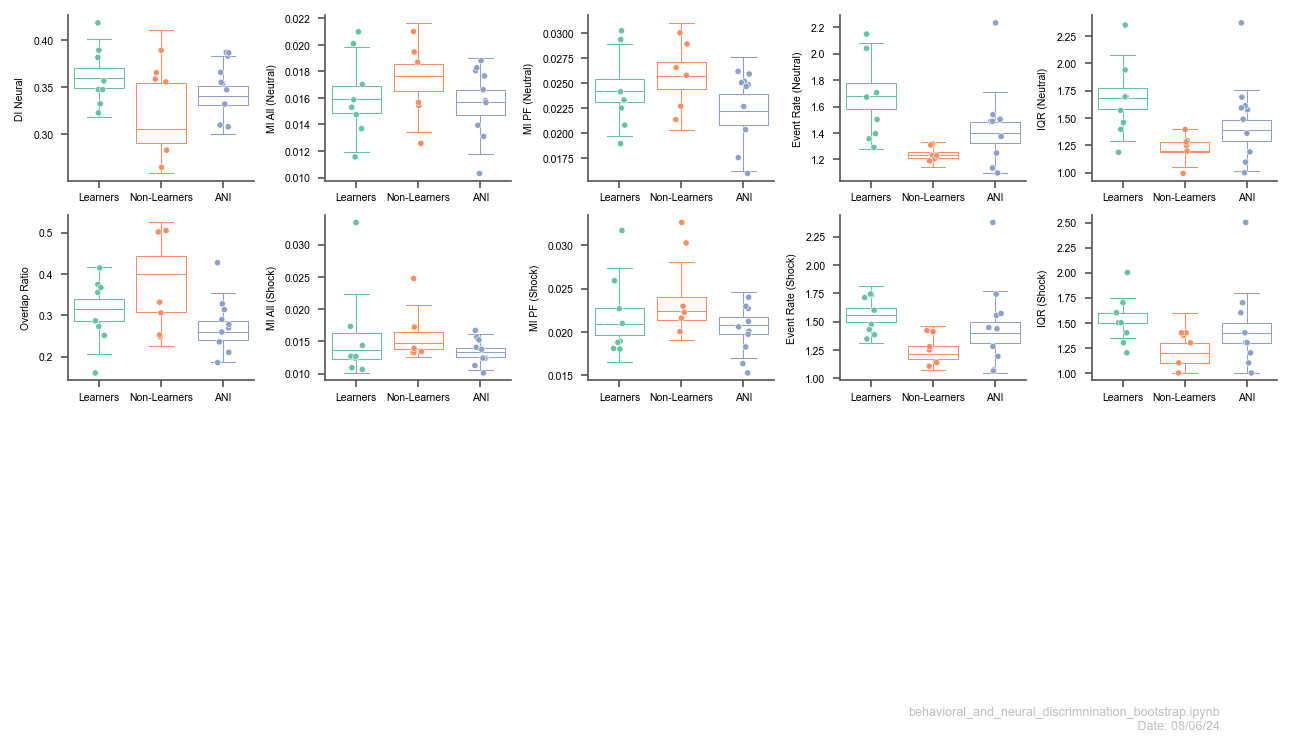

In [45]:
metrics = ["DI Neural", "MI All (Neutral)", "MI PF (Neutral)", "Event Rate (Neutral)", "IQR (Neutral)",
           "Coactive", "MI All (Shock)",  "MI PF (Shock)", "Event Rate (Shock)", "IQR (Shock)"]
comps = [["Learners", "Non-Learners"], ["Learners", "ANI"], ["Non-Learners", "ANI"]]
n_iter = 10000
palette = sns.color_palette(palette='Set2', as_cmap=False)[0:3]

for idm, metric in enumerate(metrics):

    # Skip boostrapping for IQR if already calculated during event rate bootstrappin:
    if ((metric == "IQR (Neutral)") & ("Event Rate (Neutral)" in df_metric.keys())) | ((metric == "IQR (Shock)") & ("Event Rate (Shock)" in df_metric.keys())):
        print("Skipping bootstrapping for IQR because already done")
    else:    
        df_bs = []
        
        df_metric = create_full_neural_metric_df(fratio_df_all, metric)
        df_metric["Group"] = df_metric.apply(get_group, axis=1)
        df_metric = df_metric[(df_metric.Day == 1) | (df_metric.Day == 2)]  # Grab only values for AFTER days
        print(f"Metric #{idm} ({metric}) bootstrapping")
        for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                    [err.learners, err.nonlearners, err.ani_mice_good]):
            df_list = []
            df_use = df_metric[df_metric.Group == group_name].drop(columns="Group")
            means, iqr = [], []
            print(f"Bootstrapping for {group_name} group")
            for ii in tqdm(range(n_iter)):
                t = resample(df_use, level=["Mouse", "Day", metric], n_level=[None, 1, None])
                if metric in "DI Neural":
                    means.append(np.mean(np.abs(t[metric].values)))
                else:
                    means.append(np.mean(t[metric].values))
                    if "Event Rate" in metric:
                        iqr.append(sstats.iqr(t[metric].values))
            
            if "Event Rate" in metric:
                df_bs.append(pd.DataFrame({"Group": group_name, metric: means, f"IQR {metric.split(' ')[-1]}": iqr}))
            else:
                df_bs.append(pd.DataFrame({"Group": group_name, metric: means}))
                
        df_bs = pd.concat(df_bs, axis=0)
    
    ax = FigDI2acomb.subplot((FigDI2a.gs.nrows, FigDI2a.gs.ncols, 1 + idm))

    if metric == "DI Neural":
        df_metric[metric] = np.abs(df_metric[metric])
    if "IQR" in metric:
        df_mean = df_metric.drop(columns=["Group"]).groupby(["Mouse", "Day"]).apply(sstats.iqr).reset_index()
        df_mean = df_mean.rename(columns={0: f"IQR {metric.split(' ')[-1]}"})
    else:
        df_mean = df_metric.groupby(["Mouse", "Day"]).mean(numeric_only=True).reset_index()
    df_mean["Group"] = pd.Categorical(df_mean.apply(get_group, axis=1), ["Learners", "Non-Learners", "ANI"])
    
    sns.boxplot(data=df_bs, x="Group", y=metric, palette=palette, showfliers=False, hue="Group", 
                linewidth=0.5, fill=False, legend=False, ax=ax[0])
    sns.stripplot(data=df_mean, x="Group", y=metric, palette=palette, size=3, linewidth=0.3, edgecolor="w", hue="Group", 
                  legend=False, ax=ax[0])
    ax[0].set_xlabel("")
    if metric == "Coactive":
        ax[0].set_ylabel("Overlap Ratio")
    
    ax[1].text(0.1, 0.9, f"bootstrap test stats for {metric}")
    for idg, (grp1, grp2) in enumerate(comps):
        stat, pval = get_bootstrap_prob(df_bs[df_bs.Group == grp1][metric], df_bs[df_bs.Group == grp2][metric])
        ax[1].text(0.1, 0.7 - idg * 0.2, f"{grp1} v {grp2}: pval = {pval:.3g}, test_stat = {stat:0.3g}")
        ax[1].text(0.1, 0.6 - idg * 0.2, f"pval = {np.min((pval*len(comps), 1)):.3g} after Bonf. corr.")

FigDI2acomb.savefig(plot_path=plot_path, file_prefix="After_Neural_Metrics_Dayn1_or_n2_bs", suffix=["", "_stats"], 
                   scriptname="behavioral_and_neural_discrimnination_bootstrap.ipynb")
FigDI2a.fig

/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


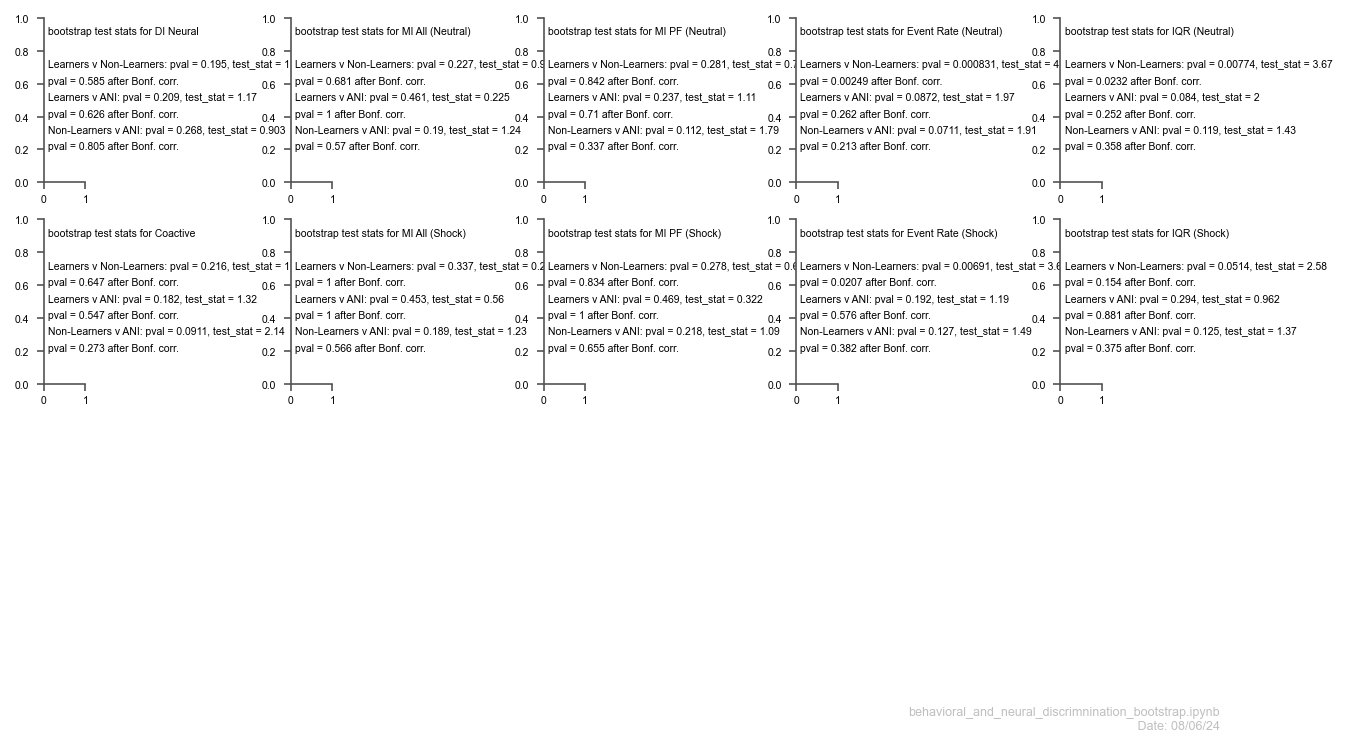

In [46]:
FigDI2astats.fig

### SBehaveD: Thigmotaxis plots
Address reviewer question regarding whether Learners and non-Learners might have different levels of anxiety prior to fear conditioning


In [6]:
df_list = []
id = 1
for grp, grp_name in zip([err.learners, err.nonlearners, err.ani_mice_good], ["Learners", "Non-Learners", "ANI"]):
    for mouse in grp:
        for arena in ["Open", "Shock"]:
            for day in [-2, -1, 0, 4, 1, 2, 7]:
                try:
                    thigmo = get_thigmotaxis(mouse, arena, day)
                    arena_name = "Neutral" if arena == "Open" else "Shock"
                    df_list.append(pd.DataFrame({"Mouse": mouse, "Arena": arena_name, "Day": day, 
                                                 "Group": grp_name, "Thigmo. Ratio": thigmo}, index=[id]))
                    id += 1
                except FileNotFoundError:
                    pass
thigmo_df = pd.concat(df_list, axis=0)
thigmo_df.sample(5)

,Mouse,Arena,Day,Group,Thigmo. Ratio
85,Marble29,Neutral,4,Non-Learners,0.953675
43,Marble27,Neutral,-1,Learners,0.658286
113,Marble18,Neutral,1,ANI,0.588308
52,Marble27,Shock,4,Learners,0.487766
89,Marble29,Shock,-2,Non-Learners,0.326251


#### Sanity check on thigmotaxis calculation
Plot trajectory with thigmotaxis ratio overlaid. Looks correct.

No position file present in /Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180426_1_openfield
No position file present in /Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180426_2_fcbox


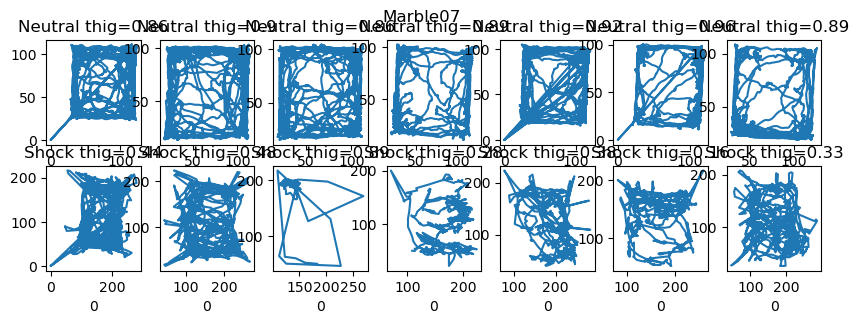

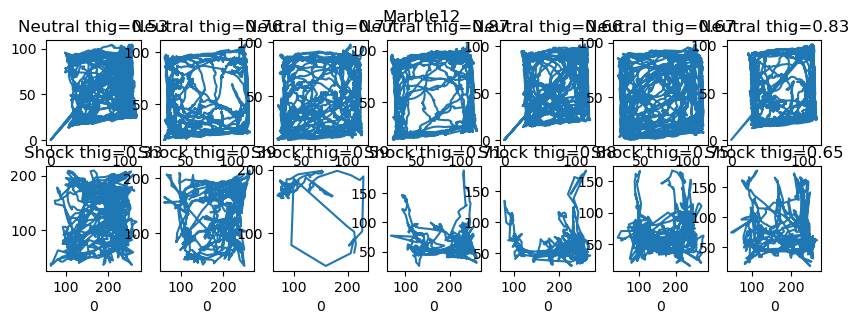

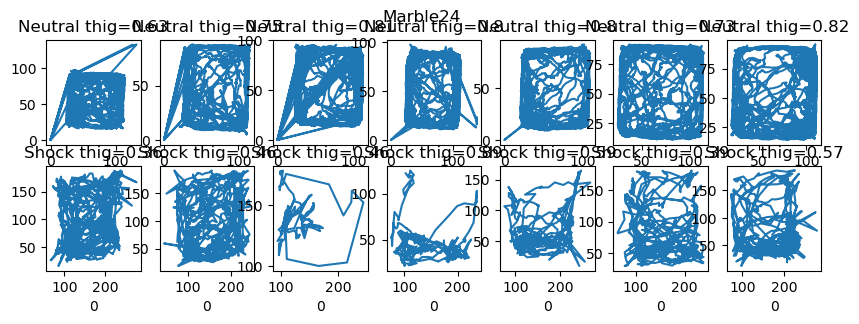

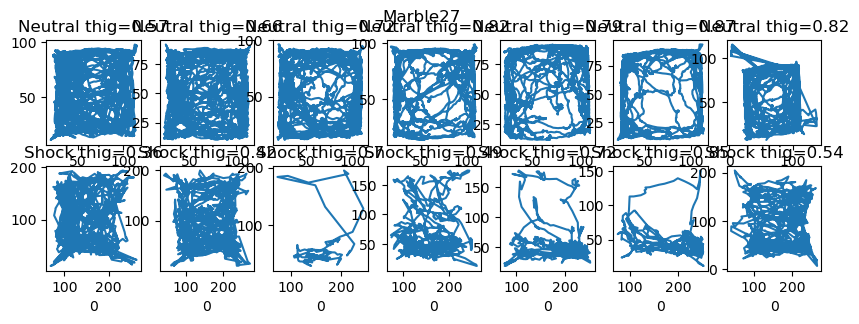

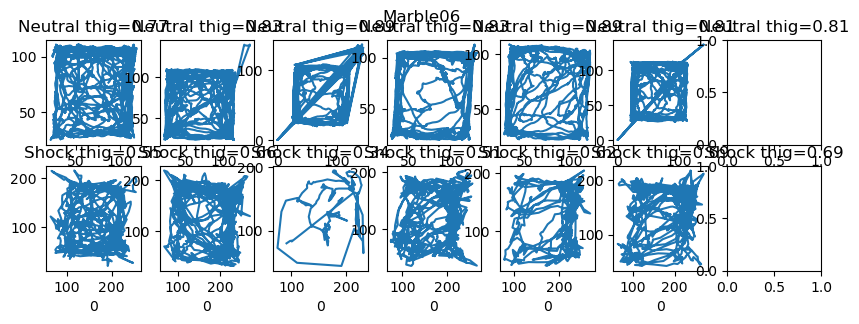

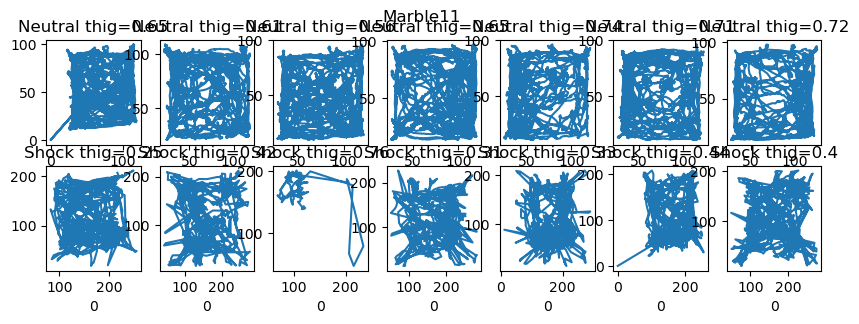

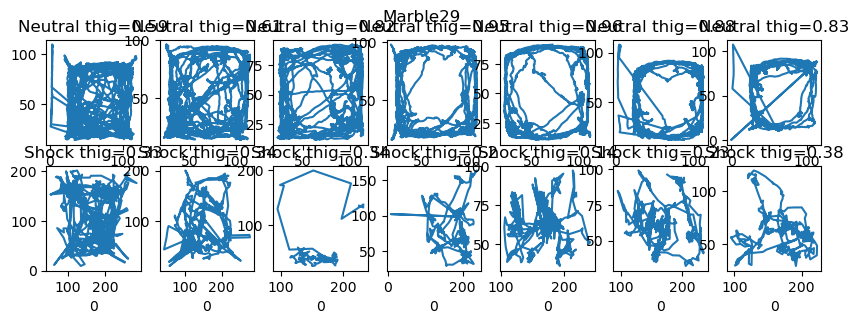

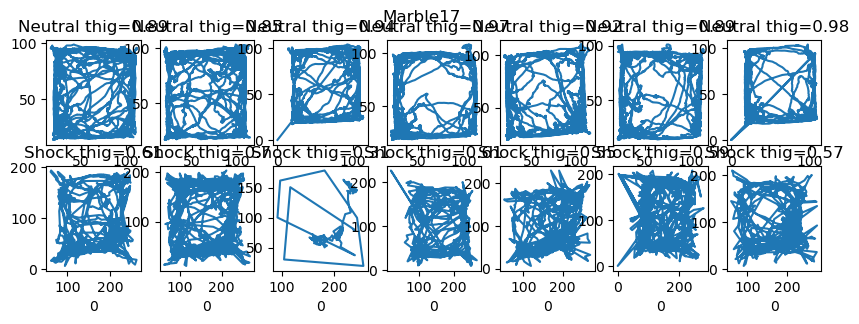

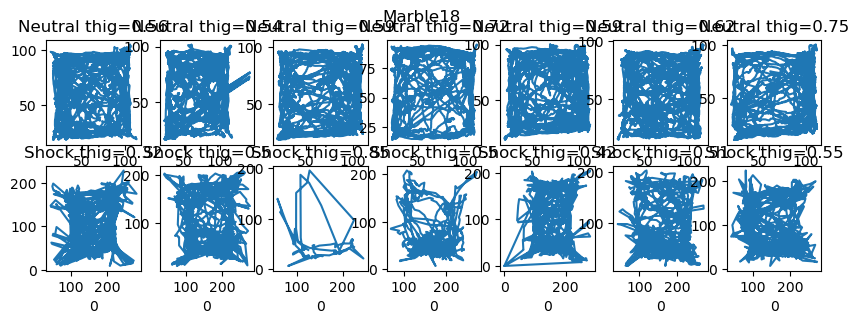

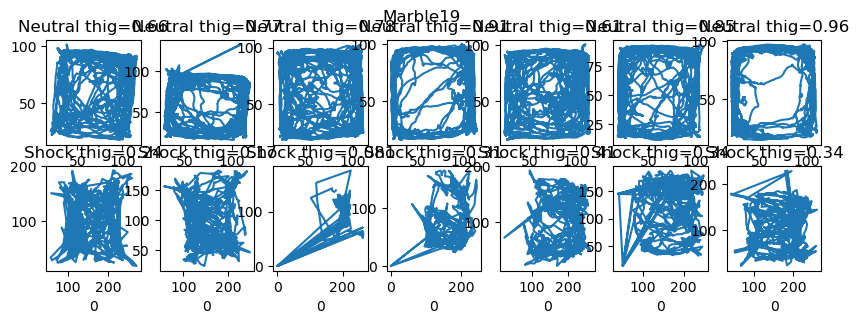

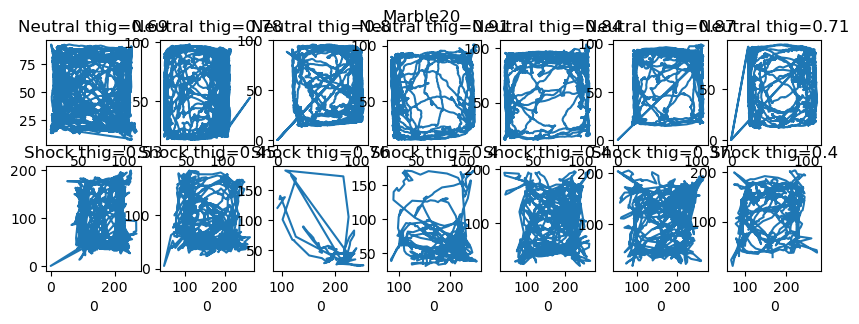

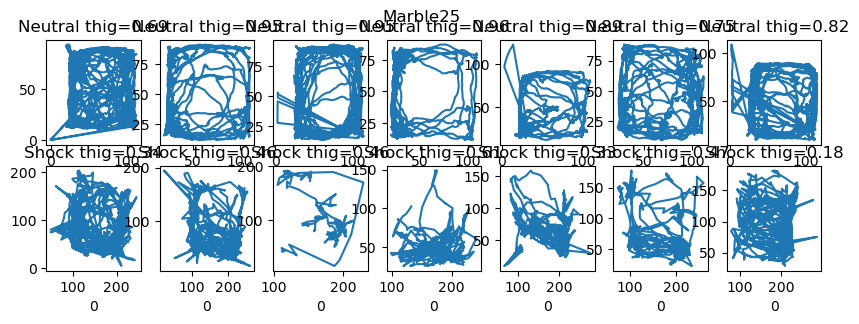

In [7]:
# sanity check
for mouse in thigmo_df.Mouse.unique():
    fig, ax = plt.subplots(2, 7, figsize=(10, 3))
    fig.suptitle(mouse)
    for ida, arena in enumerate(["Open", "Shock"]):
        for a, day in zip(ax[ida], [-2, -1, 0, 4, 1, 2, 7]):
            dir_use = er.get_dir(mouse, arena, day)
            erp.plot_frame_and_traj(a, dir_use)
            arena_str = arena if arena == "Shock" else "Neutral"
            try:
                thig_ratio = thigmo_df[(thigmo_df.Mouse == mouse) & (thigmo_df.Arena == arena_str) & (thigmo_df.Day == day)]["Thigmo. Ratio"].values[0]
            except IndexError:
                thigmo_ratio = np.nan
            a.set_title(f"{arena_str} thig={thig_ratio:.2g}")

#### Actual plots here

[8.5   4.875]
[8.5   4.875]


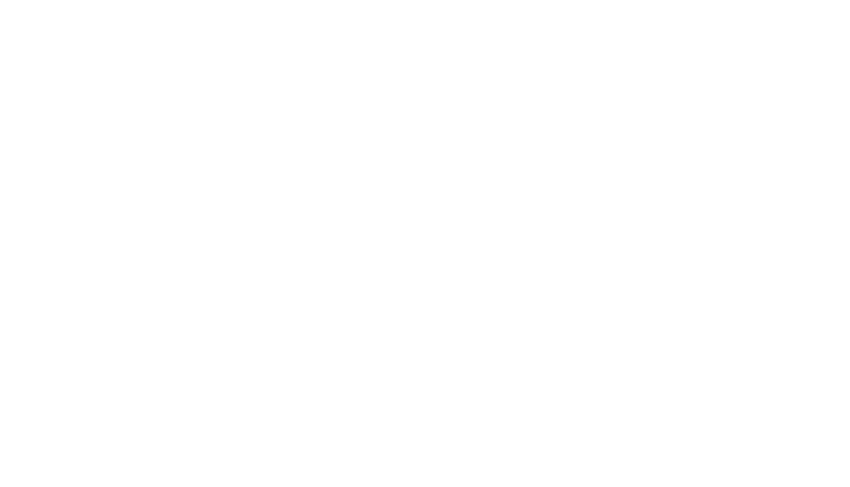

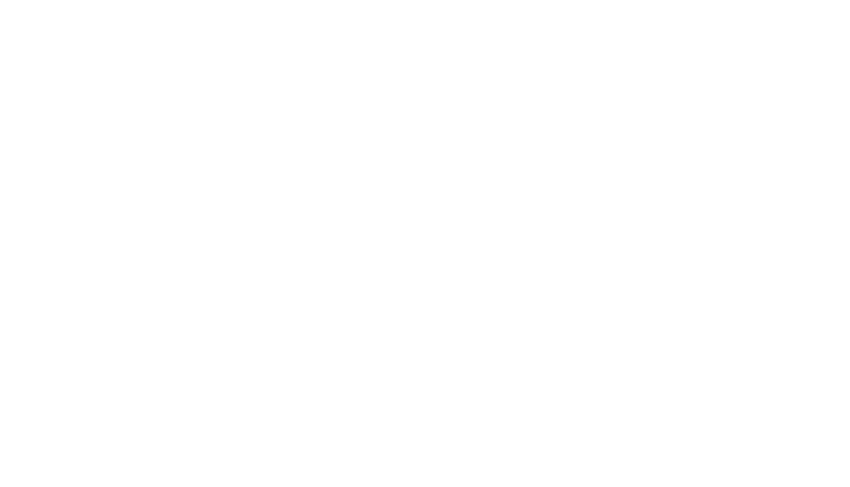

In [9]:
# Set up main figure plotting
%matplotlib ipympl
Figthig = Fig(num="Figthig", grid=(4, 5), size=(8.5, 4.875), fontsize=6)
print(Figthig.fig.get_size_inches())
# Set up main figure stats companion plot and mirror it into FigMirror class
Figthigstats = Fig(num='Figthig stats', grid=(4, 5), size=(8.5, 4.875), fontsize=6)
print(Figthigstats.fig.get_size_inches())
Figthigcomb = FigMirror(Figthig, Figthigstats)

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_93869/961454764.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_use[df_use.Arena == arena], x="Group", y="Thigmo. Ratio", ax=ax[0],
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_93869/961454764.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_use[df_use.Arena == arena], x="Group", y="Thigmo. Ratio", ax=ax[0],
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_93869/961454764.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=

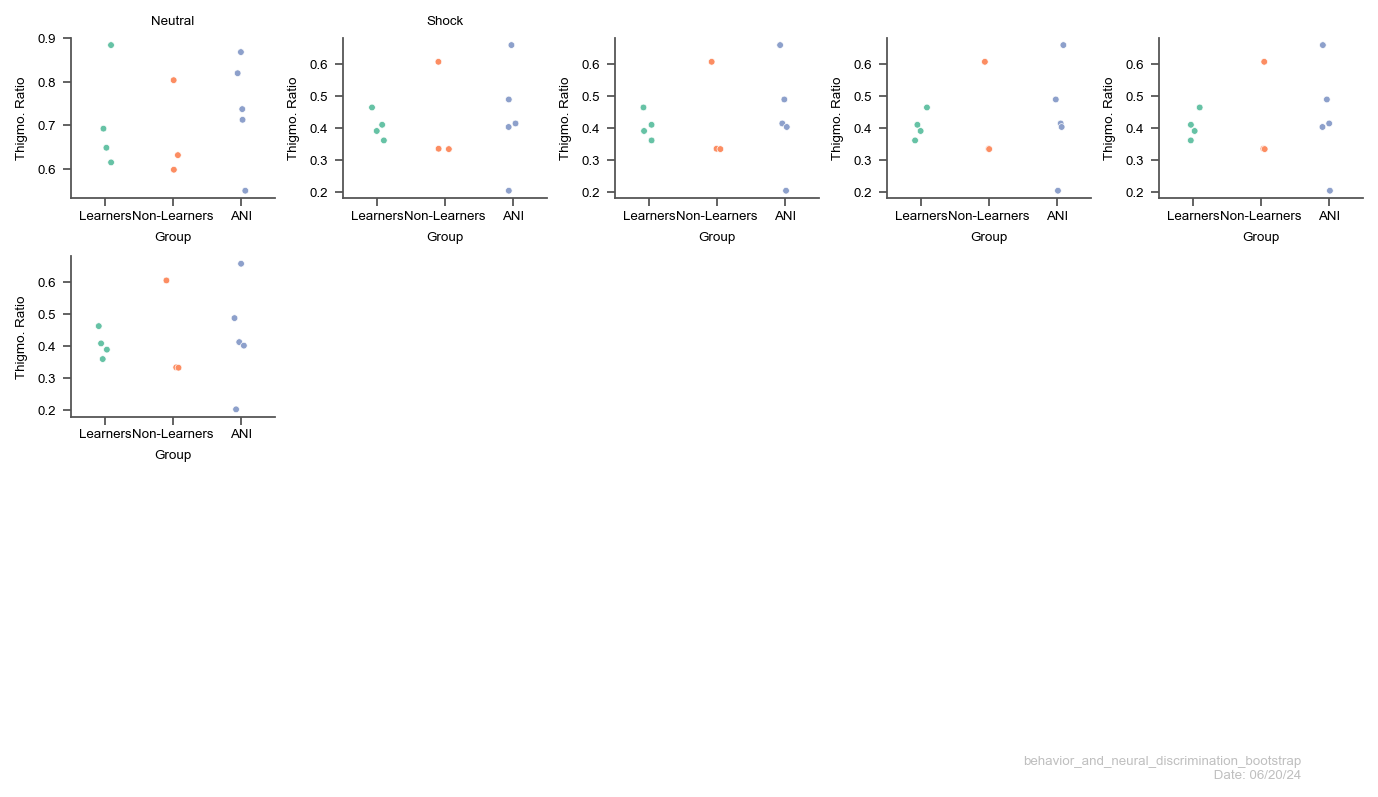

In [10]:
# _, ax = plt.subplots(1, 2, figsize=(9, 3))
palette = sns.color_palette(palette='Set2', as_cmap=False)[0:3]
# df_use = thigmo_df[(thigmo_df.Day == -2) | (thigmo_df.Day == -1)]
df_use = thigmo_df[(thigmo_df.Day == -2) | (thigmo_df.Day == -1)].groupby(["Group", "Mouse", "Arena"]).mean(numeric_only=True).reset_index()
df_use["Group"] = pd.Categorical(df_use["Group"], ["Learners", "Non-Learners", "ANI"])
astats = []
for ida, arena in enumerate(["Neutral", "Shock"]):
    ax = Figthigcomb.subplot((Figthig.gs.nrows, Figthig.gs.ncols, 1 + ida))
    astats.append(ax[1])
    sns.stripplot(data=df_use[df_use.Arena == arena], x="Group", y="Thigmo. Ratio", ax=ax[0],
                 size=3, linewidth=0.3, edgecolor='w', palette=palette)
    [a.set_title(arena) for a in ax]
    ax[1].text(0.1, 0.9, pg.anova(data=df_use[df_use.Arena == arena], dv="Thigmo. Ratio", between="Group"))
    ax[1].text(0.1, 0.1, pg.pairwise_tests(data=df_use[df_use.Arena == arena], dv="Thigmo. Ratio", between="Group"))

# Fake plot things to make everything align properly
for ida in np.arange(2, 6):
    ax = Figthigcomb.subplot((Figthig.gs.nrows, Figthig.gs.ncols, 1 + ida))
    sns.stripplot(data=df_use[df_use.Arena == arena], x="Group", y="Thigmo. Ratio", ax=ax[0],
                 size=3, linewidth=0.3, edgecolor='w', palette=palette)
Figthig.savefig(plot_path / "S1_thigmotaxis.pdf", scriptname='behavior_and_neural_discrimination_bootstrap')
Figthigstats.savefig(plot_path / "S1_thigmotaxis_stats.pdf", scriptname='behavior_and_neural_discrimination_bootstrap')
Figthig.fig    

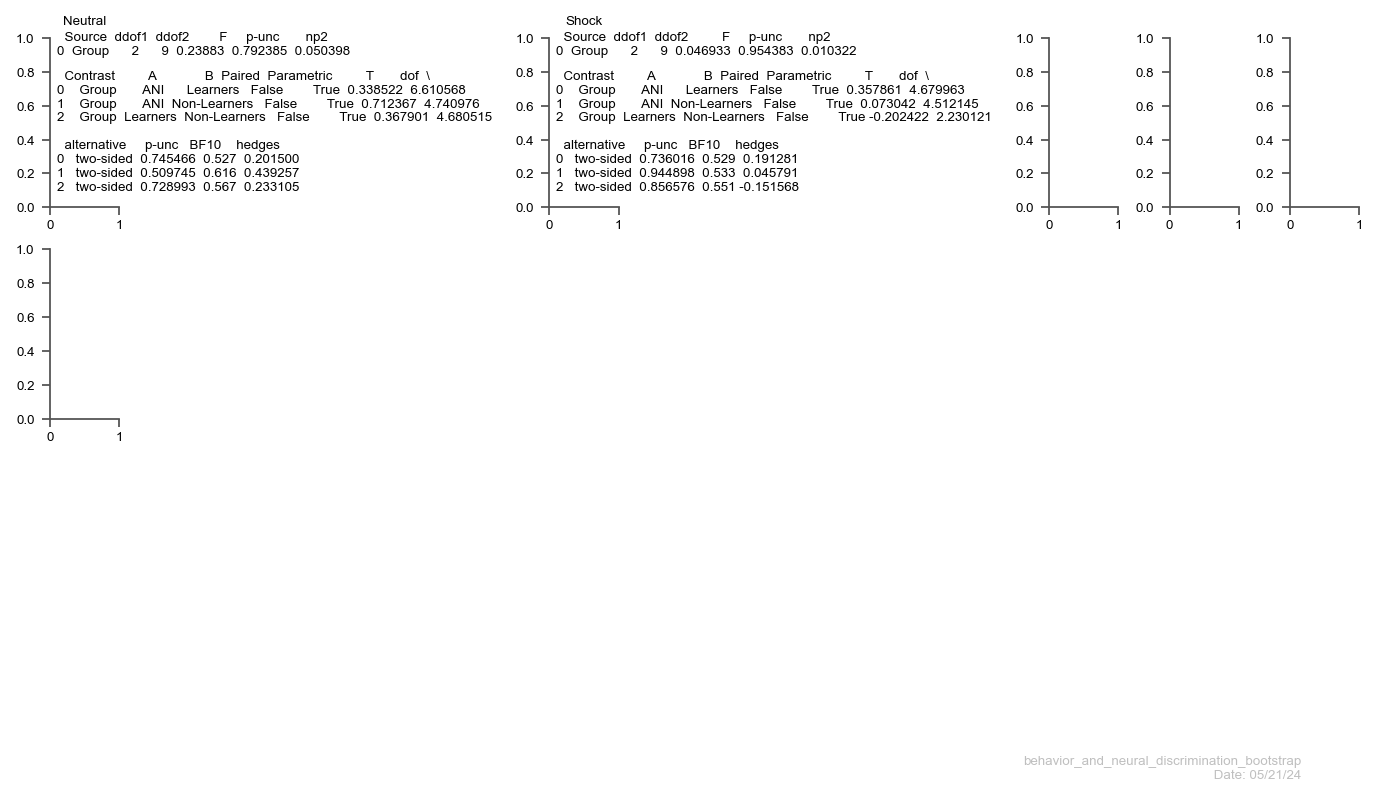

In [149]:
Figthigstats.fig